# Courbe de lumière via analyse 2D

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

In [86]:
# à partir de l'analyse 2D

from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapMaker,
    PSFKernel,
    MapDataset,
    MapMakerRing,
    RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
)
from gammapy.modeling import Fit

In [3]:
# à partir du code pour les courbes de lumière 3D

from gammapy.data import ObservationFilter
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.modeling.models import PointSpatialModel, SkyDiffuseCube

from gammapy.maps import WcsNDMap
from gammapy.irf import make_mean_edisp  # pas utile en 2D a priori
from gammapy.time import LightCurveEstimator
from astropy.coordinates import Angle

In [317]:
data_store = DataStore.from_dir("../data/ash_stereo_Prod17_Calib0834_thsq64")

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(3, 'deg'),
                 border=Angle(0, 'deg'))
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = list(selected_obs_table["OBS_ID"].data)
gc_obs = data_store.get_observations(obs_ids)

In [318]:
for obs in gc_obs:
    try:
        obs.aeff
        obs.edisp #pas utile en 2D
        obs.psf
    except:
        obs_ids.remove(obs.obs_id)
        print("Observation retirée : " + str(obs.obs_id))

observations = data_store.get_observations(obs_ids)

Found multiple HDU matching: OBS_ID = 20191, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20193, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss
Found multiple HDU matching: OBS_ID = 20194, HDU_TYPE = psf, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = psf and HDU_CLASS = psf_3gauss


Observation retirée : 20191
Observation retirée : 20193
Observation retirée : 20194
Observation retirée : 31539
Observation retirée : 31577
Observation retirée : 31578
Observation retirée : 31579
Observation retirée : 31580


In [319]:
t2004 = Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59'])
t2005 = Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59'])
t2006 = Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59'])
t2007 = Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59'])
t2008 = Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59'])
t2009 = Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59'])
t2010 = Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59'])
t2011 = Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59'])
t2012 = Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59'])
t2013 = Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59'])
t2014 = Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59'])
t2015 = Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59'])
t2016 = Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59'])
t2017 = Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59'])
t2018 = Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59'])
t2019 = Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59'])

year_intervals = [t2004, t2005,t2006, t2007,t2008, t2009,t2010, t2011,t2012, t2013,t2014, t2015,t2016, t2017,t2018, t2019]

In [320]:
obs2004 = observations.select_time(t2004)
obs2005 = observations.select_time(t2005)
obs2006 = observations.select_time(t2006)
obs2007 = observations.select_time(t2007)
obs2008 = observations.select_time(t2008)
obs2009 = observations.select_time(t2009)
obs2010 = observations.select_time(t2010)
obs2011 = observations.select_time(t2011)
obs2012 = observations.select_time(t2012)
obs2013 = observations.select_time(t2013)
obs2014 = observations.select_time(t2014)
obs2015 = observations.select_time(t2015)
obs2016 = observations.select_time(t2016)
obs2017 = observations.select_time(t2017)
obs2018 = observations.select_time(t2018)
obs2019 = observations.select_time(t2019)

obs_set = [obs2004,obs2005,obs2006,obs2007,obs2008,obs2009,obs2010,obs2011,obs2012,obs2013,obs2014,obs2015,obs2016,obs2017,obs2018,obs2019]

In [321]:
# Target definition
target_position = SkyCoord(359.94, -0.04, frame="galactic", unit="deg")

# Define geoms
emin, emax = [0.5, 100] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 10, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.03,
    width=(3, 3),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2D = WcsGeom.create(
    skydir=target_position,
    binsz=0.03,
    width=(3, 3),
    coordsys="GAL",
    proj="CAR",
)

In [322]:
# on essaie de pas refaire tout ça
maker = MapMaker(geom, offset_max=2.5 * u.deg)

spectrum = PowerLaw2SpectralModel(index=2.3)

In [323]:
%%time

# maps 3D de taille (50, 50, 1)

maps2D2004 = maker.run_images(obs2004, spectrum=spectrum, keepdims=True)
maps2D2005 = maker.run_images(obs2005, spectrum=spectrum, keepdims=True)
maps2D2006 = maker.run_images(obs2006, spectrum=spectrum, keepdims=True)
maps2D2007 = maker.run_images(obs2007, spectrum=spectrum, keepdims=True)
maps2D2008 = maker.run_images(obs2008, spectrum=spectrum, keepdims=True)
maps2D2009 = maker.run_images(obs2009, spectrum=spectrum, keepdims=True)
maps2D2010 = maker.run_images(obs2010, spectrum=spectrum, keepdims=True)
maps2D2011 = maker.run_images(obs2011, spectrum=spectrum, keepdims=True)
maps2D2012 = maker.run_images(obs2012, spectrum=spectrum, keepdims=True)
maps2D2013 = maker.run_images(obs2013, spectrum=spectrum, keepdims=True)
maps2D2014 = maker.run_images(obs2014, spectrum=spectrum, keepdims=True)
maps2D2015 = maker.run_images(obs2015, spectrum=spectrum, keepdims=True)
maps2D2016 = maker.run_images(obs2016, spectrum=spectrum, keepdims=True)
maps2D2017 = maker.run_images(obs2017, spectrum=spectrum, keepdims=True)
maps2D2018 = maker.run_images(obs2018, spectrum=spectrum, keepdims=True)
maps2D2019 = maker.run_images(obs2019, spectrum=spectrum, keepdims=True)

CPU times: user 2min 6s, sys: 7.92 s, total: 2min 14s
Wall time: 2min 18s


In [353]:
maps2Dbis = []

for obs in obs_set:
    maker = MapMaker(geom, offset_max=2.5 * u.deg)
    maps2Dbis.append(maker.run_images(obs, spectrum=spectrum, keepdims=True))

In [362]:
maps2Dbis[0]["counts"].data - maps2Dbis[1]["counts"].data

array([[[ -2.,  -1.,  -2., ...,  -2., -10.,   0.],
        [  1.,   5.,  -3., ...,  -1.,  -1.,  -1.],
        [  3.,  -1.,  -1., ...,   0.,  -3.,  -1.],
        ...,
        [ -2.,   4.,  -2., ...,   0.,   1.,   2.],
        [  0.,  -1.,  -1., ...,  -8.,  -4.,  -5.],
        [  8.,   1.,   5., ...,   3.,   0.,  -1.]]], dtype=float32)

In [163]:
from pathlib import Path

path = Path("cartes2D_gc_temporelle_Emin500GeV")

In [164]:
def readmaps(year, path=path) :

    mapc = Map.read(str(path / "counts") + year +".fits")
    mapb = Map.read(str(path / "background") + year +".fits")
    mape = Map.read(str(path / "exposure")+ year +".fits")

    return {"counts " : mapc , "background" : mapb , "exposure" : mape}

In [165]:
# Cartes avec des bins en espace très fins (500, 400, 1)

mapL2004 = readmaps("2004")
mapL2005 = readmaps("2005")
mapL2006 = readmaps("2006")
mapL2007 = readmaps("2007")
mapL2008 = readmaps("2008")
mapL2009 = readmaps("2009")
mapL2010 = readmaps("2010")
mapL2011 = readmaps("2011")
mapL2012 = readmaps("2012")
mapL2013 = readmaps("2013")
mapL2014 = readmaps("2014")
mapL2015 = readmaps("2015")
mapL2016 = readmaps("2016")
mapL2017 = readmaps("2017")
mapL2018 = readmaps("2018")
mapL2019 = readmaps("2019")

In [324]:
%%time

def Calculate_psf_kernel(obs, maps2D):
    geom2d = maps2D["exposure"].geom
    table_psf = make_mean_psf(obs, target_position)

    table_psf_2d = table_psf.table_psf_in_energy_band((emin, emax), spectrum=spectrum)

    # PSF kernel used for the model convolution
    psf_kernel = PSFKernel.from_table_psf(table_psf_2d, geom2d, max_radius="0.3 deg")
    return psf_kernel



CPU times: user 2min 34s, sys: 2.87 s, total: 2min 37s
Wall time: 2min 46s


In [ ]:
psf_kernel2004 = Calculate_psf_kernel(obs2004, maps2D2004)
psf_kernel2005 = Calculate_psf_kernel(obs2005, maps2D2005)
psf_kernel2006 = Calculate_psf_kernel(obs2006, maps2D2006)
psf_kernel2007 = Calculate_psf_kernel(obs2007, maps2D2007)
psf_kernel2008 = Calculate_psf_kernel(obs2008, maps2D2008)
psf_kernel2009 = Calculate_psf_kernel(obs2009, maps2D2009)
psf_kernel2010 = Calculate_psf_kernel(obs2010, maps2D2010)
psf_kernel2011 = Calculate_psf_kernel(obs2011, maps2D2011)
psf_kernel2012 = Calculate_psf_kernel(obs2012, maps2D2012)
psf_kernel2013 = Calculate_psf_kernel(obs2013, maps2D2013)
psf_kernel2014 = Calculate_psf_kernel(obs2014, maps2D2014)
psf_kernel2015 = Calculate_psf_kernel(obs2015, maps2D2015)
psf_kernel2016 = Calculate_psf_kernel(obs2016, maps2D2016)
psf_kernel2017 = Calculate_psf_kernel(obs2017, maps2D2017)
psf_kernel2018 = Calculate_psf_kernel(obs2018, maps2D2018)
psf_kernel2019 = Calculate_psf_kernel(obs2019, maps2D2019)

In [354]:
psf_kernelsbis = []

for obs,maps2D in zip(obs_set,maps2Dbis):
    psf_kernelsbis.append(Calculate_psf_kernel(obs, maps2D))

In [325]:
maps2D = [maps2D2004,maps2D2005,
        maps2D2006,maps2D2007,
        maps2D2008, maps2D2009,
        maps2D2010,maps2D2011,
        maps2D2012,maps2D2013, 
        maps2D2014, maps2D2015, 
        maps2D2016, maps2D2017, 
        maps2D2018, maps2D2019]

psf_kernels = [psf_kernel2004 ,psf_kernel2005,
               psf_kernel2006,psf_kernel2007 ,
               psf_kernel2008,psf_kernel2009,
               psf_kernel2010,psf_kernel2011,
               psf_kernel2012 ,psf_kernel2013 ,
               psf_kernel2014 ,psf_kernel2015 ,
               psf_kernel2016,psf_kernel2017 ,
               psf_kernel2018, psf_kernel2019]

In [355]:
# Define the source model - Use a pointsource + integrated power law model to directly get flux

spatial_model = PointSpatialModel(
    lon_0=target_position.l, lat_0=target_position.b, frame="galactic"
)

spectral_model = PowerLawSpectralModel(
    index=2.3,
    amplitude=2.0e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

spectral_model.parameters["index"].frozen = True

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="SgrA*"
)

sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True

In [356]:
CS_map = Map.read("../data/CS_reproj.fits")

CS_reproj = CS_map.reproject(geom2D)

CS_distro_model = TemplateSpatialModel(CS_reproj)


# pas besoin (à convoluer avec une gaussienne de sigma de 0.9°)

# inutile
#gauss = GaussianSpatialModel(target_position.l, target_position.b, sigma= "0.9 deg", frame="galactic")

# NON some_map_convolved = some_map.convolve(psf_kernel)
# NON donc la bonne méthode c'est de prendre la distro de CS et de la convoluer par la PSF de chaque année

spectral_diffuse_model = PowerLawSpectralModel(
    index=2,
    amplitude=2.0e-12 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_diffuse_model = SkyModel(
    spatial_model=CS_distro_model, 
    spectral_model=spectral_diffuse_model, 
    name="diffuse emission"
)

sky_diffuse_model.parameters["index"].frozen = True

Invalid value BUNIT='Count' in FITS header. Setting empty unit.
/Users/user/anaconda3/envs/gammapy-0.14/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):
Diffuse map has negative values. Check and fix this!


In [306]:
def fit_model_to_maps(maps2D, psf_kernel):
    region = CircleSkyRegion(center=target_position, radius=1 * u.deg)
    mask = maps2D["counts"].geom.region_mask([region])
    print(mask.shape, maps2D["counts"].data.shape)
    background_model = BackgroundModel(maps2D["background"])
    background_model.parameters["norm"].frozen = False
    background_model.parameters["tilt"].frozen = True

    dataset = MapDataset(
        model=sky_model + sky_diffuse_model,
        counts=maps2D["counts"],
        exposure=maps2D["exposure"],
        background_model=background_model,
        mask_fit=mask,
        psf=psf_kernel,
    )
    fit = Fit(dataset)
    result = fit.run()
    return result

In [222]:
result = fit_model_to_maps(maps2D2004, psf_kernel2004)

(1, 50, 50) (1, 50, 50)


In [250]:
t = result.parameters.to_table()

In [251]:
t

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,4.593e-12,1.618e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.405e+00,9.962e-01,,nan,nan,False
index,2.000e+00,0.000e+00,,nan,nan,True
amplitude,2.811e-12,1.993e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [386]:
%%time

region = CircleSkyRegion(center=target_position, radius=1 * u.deg)
mask = maps2Dbis[0]["counts"].geom.region_mask([region])


datasets = []
results = []

for  maps, psf_kernel in zip(maps2Dbis, psf_kernelsbis):
    
    background_model = BackgroundModel(maps["background"])
    background_model.parameters["norm"].frozen = False
    background_model.parameters["tilt"].frozen = True

    dataset = MapDataset(
        model=sky_model + sky_diffuse_model,
        counts=maps["counts"],
        exposure=maps["exposure"],
        background_model=background_model,
        mask_fit=mask,
        psf=psf_kernel,
    )
    
    datasets.append(dataset)
    fit = Fit(dataset)
    result = fit.run()
    results.append(result.parameters)

CPU times: user 45.7 s, sys: 666 ms, total: 46.4 s
Wall time: 47 s


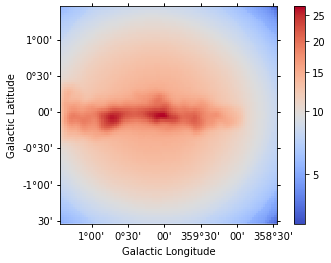

In [387]:
datasets[0].npred().plot_interactive(
    cmap="coolwarm", add_cbar=True
)

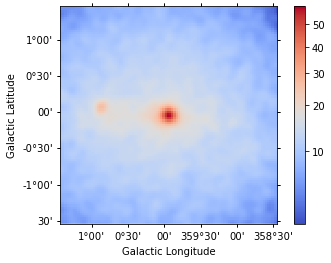

In [388]:
maps2Dbis[0]["counts"].smooth(width=0.05 *u.deg).plot_interactive(
    cmap="coolwarm", add_cbar=True
)

In [389]:
residual2004 = maps2Dbis[0]["counts"] - datasets[0].npred()

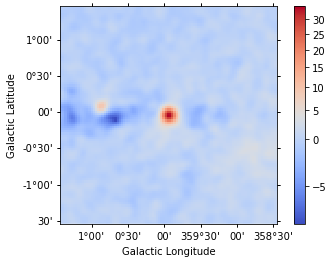

In [390]:
residual2004.smooth(width=0.05 * u.deg).plot_interactive(
    cmap="coolwarm", add_cbar=True
);

In [391]:
residuals = []

for k in range(15):
    residuals.append(maps2D[k]["counts"]- datasets[k].npred())

KeyError: 0

In [392]:
residuals[0].smooth(width=0.05 * u.deg).plot_interactive(
    cmap="coolwarm",add_cbar=True
);

IndexError: list index out of range

In [347]:
(maps2D[1]["counts"]).data

array([[[6., 4., 3., ..., 6., 2., 3.],
        [7., 6., 3., ..., 5., 7., 2.],
        [7., 4., 5., ..., 6., 7., 5.],
        ...,
        [2., 6., 4., ..., 6., 5., 4.],
        [4., 6., 4., ..., 3., 4., 2.],
        [9., 5., 8., ..., 6., 4., 4.]]], dtype=float32)

In [396]:
# problème : l'amplitude du spectre de la source est négatif et très grand en valeur absolue, et les résultat sont les mêmes pour chaque année (peut être pas un problème)
print(results[2])

Parameters

	lon_0        (frozen)   : 359.940  deg
	lat_0        (frozen)   : -0.040  deg
	index        (frozen)   : 2.300  
	amplitude               : -3.53e+02  1 / (cm2 s TeV)
	reference    (frozen)   : 1.000  TeV
	norm                    : 2.250  
	index        (frozen)   : 2.000  
	amplitude               : 4.21e-12  1 / (cm2 s TeV)
	reference    (frozen)   : 1.000  TeV
	norm                    : 1.020  
	tilt         (frozen)   : 0.000  
	reference    (frozen)   : 1.000  TeV



In [368]:
print(fit)